Path integration means that the animal is able to continuously compute its present location from its past trajectory and, as a consequence, to
return to the starting point by choosing the direct route rather than retracing its outbound trajectory

## Path integration

The method to determine the path integration of the fly will be describe and define here. 

Implementing path integration in the NeuroMechFly model involves estimating the fly's position and heading by integrating self-motion cues, primarily derived from proprioceptive and tactile feedback. I

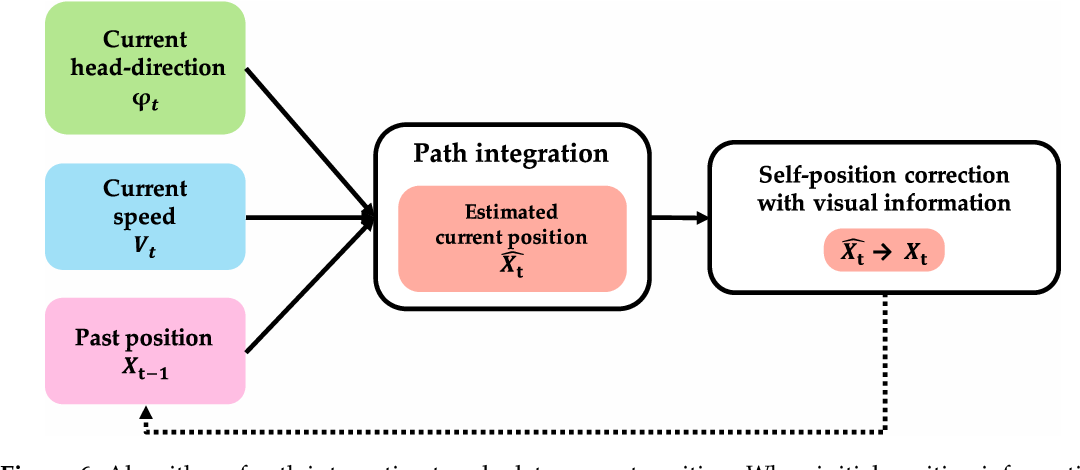

While the ant takes an exploratory outbound path in search of a food source, it can return to the nest in a straight line. Furthermore, if the experimenter moves the ant to a different location upon finding the food, the ant still takes the “correct” path back to the nest, but starting from the location where it has been “air dropped” (as shown below). These results show that the ant must be using idiothetic cues, rather than sensory input, to navigate — similar to how sailors used to navigate featureless oceans by “dead reckoning.”

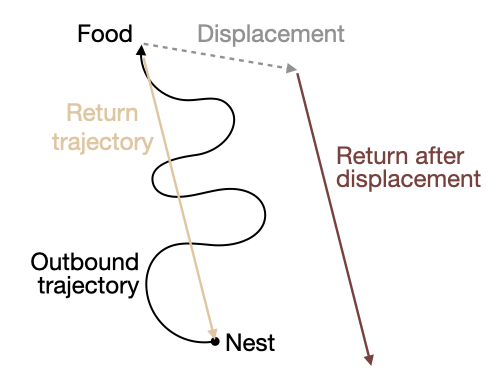

While the source of the idiothetic cues are unknown, they may, in principle, be derived using ascending proprioceptive and tactile signals from the legs and motor system. Attempt to estimate the changes in the fly’s orientation (shown below in green) and displacement (shown below in purple) based on proprioceptive and tactile information. By integrating these changes over time, we aim to reconstruct the path of the fly in space (right).

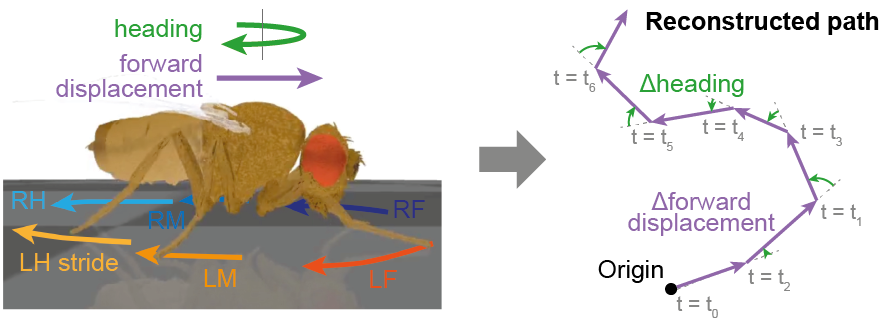

So we have to compute two quantities : forward displacement and heading.

To calculate the change in the fly’s forward displacement, we first have to accumulate the forward displacement from one step to the next over the whole simulation

For this project, i will use the path integration of desert ants, since they return to they originally "drop zone" when they have reached their target.

Path integration in desert ants

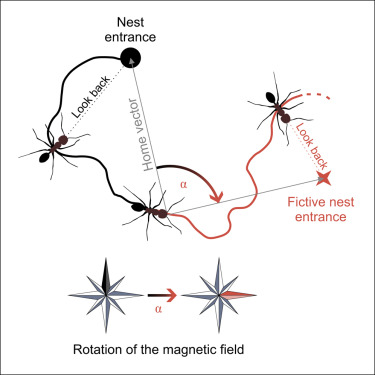

Les fourmis utilise le principe d'erreur angulaire.

# Code

Data collection : Collect join angle and leg positions over time. Ensuitem, determiner which leg is in stance phases (c'est uniquement lorsque la patte touche le sol que cela va contribuer au deplacement), cela pousse le corp vers l'avant.

Available keys in obs: ['joints', 'end_effectors', 'contact_forces', 'heading', 'velocity', 'fly', 'odor_intensity', 'vision', 'vision_updated', 'reached_odour']

Joint Angles: [ 0.43174161  0.97299476  0.05525102 -2.15747429  0.68081261  1.64027535
 -0.58444795 -0.15121358  1.78184249  0.66850178 -1.69848204 -0.14848174
  2.11099537 -0.62441119  0.68083087  2.40212304  0.47365111 -1.57809035
 -0.23225279  1.99498811 -0.19889505  0.43162386 -0.97290726 -0.05521057
 -2.15743216 -0.68068743  1.64023658 -0.58449501 -0.15171623 -1.78182526
 -0.66811881 -1.69879968  0.14815442  2.11081437 -0.62436026  0.68072799
 -2.40199742 -0.47370053 -1.57827097  0.23227888  1.99517236 -0.19885215]

Leg Positions (end_effectors): [[ 1.9266415   0.17846909]
 [-0.0689977   2.2230382 ]
 [-2.245413    1.2097257 ]
 [ 1.9266415  -0.19308805]
 [-0.0689977  -2.237657  ]
 [-2.245413   -1.2243447 ]]
 
Stance Phases (from contact forces): [np.False_, np.False_, np.False_, np.False_, np.False_, np.False_]

From the "stance phases" : True means the leg is in stance phase (touching and pushing on the ground).

False means the leg is in swing phase (lifted off the ground).

In Drosophila, the most common gait during steady walking is the tripod gait:

    Tripod gait = 3 legs in stance, 3 in swing, alternating in a coordinated pattern.

    So at most timesteps, you’d expect:
    ~3 legs in stance (True), ~3 in swing (False).

## Estimate mvt deltas

To estimate changes in heading from leg movements, we can exploit the asymmetry between left and right leg displacements during stance. This is biologically inspired: when the right legs push more than the left legs, the animal tends to turn left, and vice versa.

Turning results from uneven forward displacement between the left and right side legs.

If the left legs move farther forward (in the body frame), the fly turns right, and vice versa.

We will assume, for the legs disposition 

    Left legs = [0, 2, 4] (e.g., L1, L2, L3)

    Right legs = [1, 3, 5] (e.g., R1, R2, R3)

La mouche 

0-1

2-3

4-5

-...-

-...-

-...-

Last finding 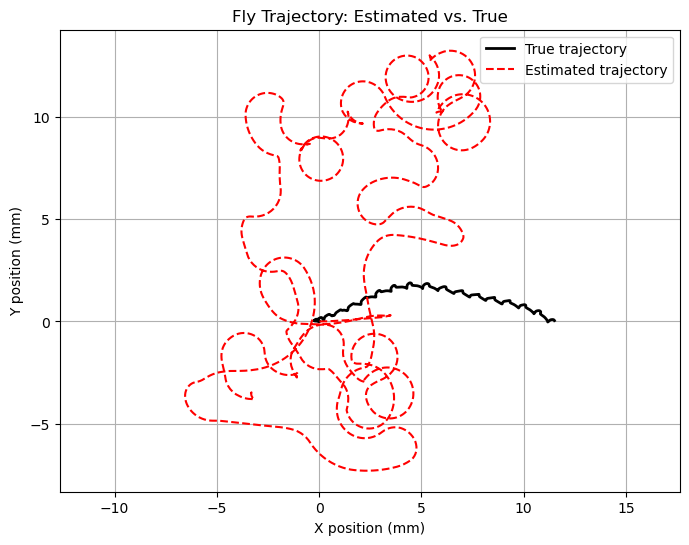

On essaye de debuger le problème. A la place d'utiliser les données internes de la mouche (idiopathic), on va debuger en utilisant les données environmentales (c'est  vraiment pas le must mais ca permet de voir si le reste du code suit ou non.)

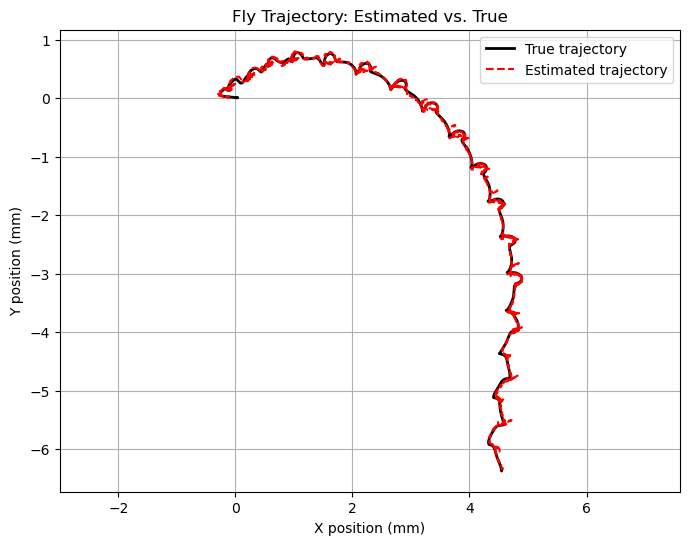

Cela veut dire que le leg displacements and integration code are not the main problem. The trajectory storage, update logic, and even most of the math in update_position() are working as expected.

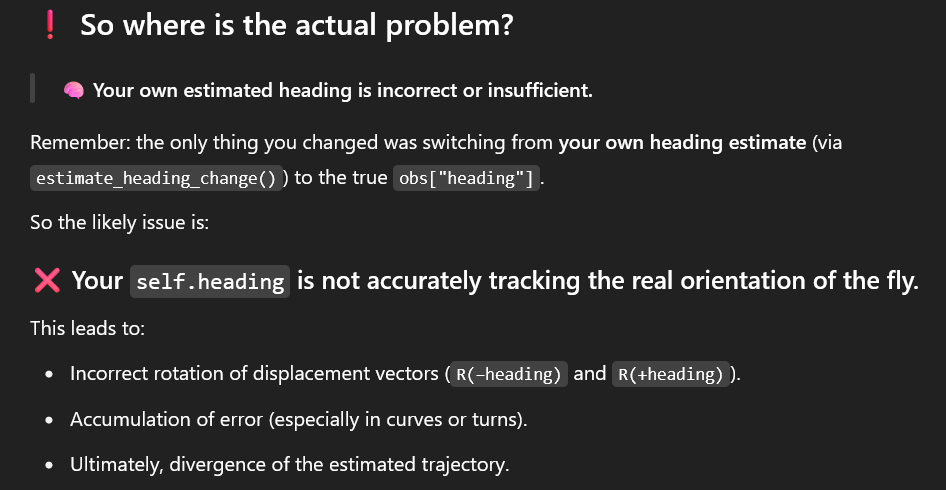

A revenir dessus.

Implementation Steps
1. Data Collection

    Proprioceptive Data: Collect joint angles and leg positions over time.

    Tactile Feedback: Determine when each leg is in contact with the ground to identify stance phases.


2. Estimate Movement Deltas

    Stride Lengths: For each leg, calculate the forward displacement during the stance phase.


    Heading Changes: Estimate changes in heading by analyzing asymmetries in left-right stride lengths.


    Forward Displacement: Sum the stride lengths to estimate forward movement.


3. Integrate Over Time

    Position Update: Use the estimated heading and displacement to update the fly's position in a 2D plane.


    Time Scaling: Normalize the deltas over a defined time window to maintain accuracy.


4. Controller Design

    Random Exploration: Implement a controller that alternates between forward walking and random turning, simulating exploratory behavior.


    Odor Source Detection: Incorporate an olfactory model to detect the odor source and trigger homing behavior.

    Homing Behavior: Once the odor source is found, use the integrated path to navigate back to the starting point.

Pour le mouvement, on veut travailler avec le tripod gait 



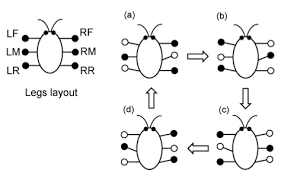

<!-- # import numpy as np
# import random
# from cobar_miniproject.base_controller import Action, BaseController, Observation
# from .utils import get_cpg, step_cpg
# from typing import NamedTuple


# class CommandWithImportance(NamedTuple):
#     left_descending_signal: float
#     right_descending_signal: float
#     importance: float  # 0->1


# class Controller(BaseController):
#     def __init__(self, timestep=1e-4, seed=0):
#         from flygym.examples.locomotion import PreprogrammedSteps

#         self.position = np.array([0.0, 0.0])
#         self.position_trace = []

#         super().__init__()
#         self.quit = False
#         self.cpg_network = get_cpg(timestep=timestep, seed=seed)
#         self.preprogrammed_steps = PreprogrammedSteps()
#         self.timestep = timestep
#         self.time = 0

#         # Data storage
#         self.joint_angles_over_time = []
#         self.leg_positions_over_time = []

#         # Path integration state
#         self.leg_stance_history = [False] * 6
#         self.leg_stance_start_positions = [None] * 6
#         self.leg_displacements = [[] for _ in range(6)]

#         # Heading estimation A CHANGER 
#         self.heading = 0.0
#         self.heading_gain = 0.04
#         self.max_heading_change = np.deg2rad(5)
#         self.last_delta_heading = 0.0
#         self.smooth_alpha = 0.8  # exponential smoothing factor

#         # Logging
#         self.heading_trace = []

#     def get_odor_taxis(self, obs: Observation) -> CommandWithImportance:
#         # unchanged odor taxis logic
#         ODOR_GAIN, DELTA_MIN, DELTA_MAX, IMPORTANCE = -500, 0.2, 1.0, 0.5
#         I = obs["odor_intensity"][0]
#         I_left = (I[0] + I[2]) / 2
#         I_right = (I[1] + I[3]) / 2
#         asym = (I_left - I_right) / ((I_left + I_right + 1e-6) / 2)
#         s = asym * ODOR_GAIN
#         bias = abs(np.tanh(s))
#         if s > 0:
#             right = DELTA_MAX - (DELTA_MAX - DELTA_MIN) * bias
#             left = DELTA_MAX
#         else:
#             left = DELTA_MAX - (DELTA_MAX - DELTA_MIN) * bias
#             right = DELTA_MAX
#         return CommandWithImportance(left, right, IMPORTANCE)

#     def estimate_heading_change(self):
#         # Fixed tripod: legs [0,3,4] vs [1,2,5]
#         # Ce code fonctionne donc bien sur le tripod gait 
#         left_indices = [0, 3, 4]
#         right_indices = [1, 2, 5]
#         left_disp, right_disp = [], []

#         for i in left_indices:
#             if self.leg_displacements[i]:
#                 d = self.leg_displacements[i][-1][0]
#                 if abs(d) > 1e-4:
#                     left_disp.append(d)
#         for i in right_indices:
#             if self.leg_displacements[i]:
#                 d = self.leg_displacements[i][-1][0]
#                 if abs(d) > 1e-4:
#                     right_disp.append(d)

#         if left_disp and right_disp:
#             raw = (np.mean(right_disp) - np.mean(left_disp)) * self.heading_gain
#             raw = np.clip(raw, -self.max_heading_change, self.max_heading_change)
#             # exponential smoothing
#             delta = self.smooth_alpha * raw + (1 - self.smooth_alpha) * self.last_delta_heading
#             self.last_delta_heading = delta
#             return delta
#         return 0.0

#     def update_position(self, stance_phases):
#         # unchanged update_position logic
#         cos_h, sin_h = np.cos(self.heading), np.sin(self.heading)
#         rot_back = np.array([[cos_h, sin_h], [-sin_h, cos_h]])
#         total_body = np.zeros(2)
#         count = 0
#         for i in range(6):
#             if stance_phases[i] and self.leg_displacements[i]:
#                 w = self.leg_displacements[i][-1][:2]
#                 if np.linalg.norm(w) > 1e-4:
#                     b = rot_back.dot(w)
#                     total_body += b
#                     count += 1
#         if count == 0:
#             return
#         avg_body = total_body / count
#         # Foot displacement is opposite to body movement: invert
#         avg_body = -avg_body
#         rot = np.array([[cos_h, -sin_h], [sin_h, cos_h]])
#         dw = rot.dot(avg_body)
#         self.position += dw


# # Rgarde si le fait d'enlever la rotation change quelque chose
#         # total_disp = np.zeros(2)
#         # count = 0
#         # for i in range(6):
#         #     if stance_phases[i] and self.leg_displacements[i]:
#         #         disp = self.leg_displacements[i][-1][:2]
#         #         if np.linalg.norm(disp) > 1e-4:
#         #             total_disp += disp
#         #             count += 1
#         # if count == 0:
#         #     return
#         # avg_disp = total_disp / count
#         # # Invert because foot moves opposite to body
#         # avg_disp = -avg_disp
#         # self.position += avg_disp



#         self.position_trace.append(self.position.copy())
#         print(f"Estimated position: {self.position} (delta_world={dw})")

#     def get_actions(self, obs: Observation) -> Action:
#         self.time += self.timestep
#         odor = self.get_odor_taxis(obs)
#         action = np.array([odor.left_descending_signal, odor.right_descending_signal])
#         joint_angles, adhesion = step_cpg(self.cpg_network, self.preprogrammed_steps, action)
#         self.joint_angles_over_time.append(joint_angles)
#         legs = obs["end_effectors"]
#         forces = obs["contact_forces"]
#         stance = [np.linalg.norm(f) > 4 for f in forces]

#         for i in range(6):
#             if stance[i] and not self.leg_stance_history[i]:
#                 self.leg_stance_start_positions[i] = np.array(legs[i])
#             if not stance[i] and self.leg_stance_history[i]:
#                 start = self.leg_stance_start_positions[i]
#                 if start is not None:
#                     disp = np.array(legs[i]) - start
#                     self.leg_displacements[i].append(disp)
#                     print(f"Leg {i} displacement during stance: {disp}")
#                 self.leg_stance_start_positions[i] = None
#             self.leg_stance_history[i] = stance[i]








#         # Vient de l'approximation des membres. Pas utile pour debug

#         dh = self.estimate_heading_change()
#         self.heading = (self.heading + dh + np.pi) % (2 * np.pi) - np.pi


#         #Utiliser pour verifier les beug
#         # self.heading = obs["heading"]
#         # self.position = np.array(obs["fly"][0][:2])







#         self.update_position(stance)

#         print("\n--- Debug Info ---")
#         print(f"Time: {self.time:.4f} | Legs in stance: {sum(stance)}/6")
#         print(f"Stance flags: {stance}")
#         print(f"Estimated heading: {np.rad2deg(self.heading):.2f}°")
#         if "fly" in obs:
#             print(f"True position: {obs['fly'][0][:2]}, True heading: {np.rad2deg(obs['heading']):.2f}°")
#         # log heading
#         self.heading_trace.append(self.heading)
#         return {"joints": joint_angles, "adhesion": adhesion}

#     def done_level(self, obs: Observation):
#         return False

#     def reset(self, **kwargs):
#         self.cpg_network.reset()
#         self.joint_angles_over_time = []
#         self.leg_positions_over_time = []
#         self.leg_stance_history = [False] * 6
#         self.leg_stance_start_positions = [None] * 6
#         self.leg_displacements = [[] for _ in range(6)]
#         self.heading = 0.0
#         self.position = np.array([0.0, 0.0])
#         self.position_trace = []
#         self.last_delta_heading = 0.0

#     def print_total_leg_displacements(self):
#         print("\n--- Total leg displacements ---")
#         for i, dlist in enumerate(self.leg_displacements):
#             tot = np.sum(dlist, axis=0) if dlist else np.array([0, 0])
#             print(f"Leg {i}: Total displacement vector = {tot}")
#         print(f"Final estimated position: {self.position}") -->


✅ What the controller is using:

    Heading is estimated from leg displacement asymmetry using estimate_heading_change().

    Position is updated via path integration from leg stance displacements in update_position().

So everything is computed purely from internal proprioception, i.e., only from leg contact data — not from any external truth.

# import numpy as np
# import random
# from cobar_miniproject.base_controller import Action, BaseController, Observation
# from .utils import get_cpg, step_cpg
# from typing import NamedTuple


# class CommandWithImportance(NamedTuple):
#     left_descending_signal: float
#     right_descending_signal: float
#     importance: float  # 0->1


# class Controller(BaseController):
#     def __init__(self, timestep=1e-4, seed=0):
#         from flygym.examples.locomotion import PreprogrammedSteps

#         self.position = np.array([0.0, 0.0])
#         self.position_trace = []

#         super().__init__()
#         self.quit = False
#         self.cpg_network = get_cpg(timestep=timestep, seed=seed)
#         self.preprogrammed_steps = PreprogrammedSteps()
#         self.timestep = timestep
#         self.time = 0

#         # Data storage
#         self.joint_angles_over_time = []
#         self.leg_positions_over_time = []

#         # Path integration state
#         self.leg_stance_history = [False] * 6
#         self.leg_stance_start_positions = [None] * 6
#         self.leg_displacements = [[] for _ in range(6)]

#         # Heading estimation A CHANGER 
#         self.heading = 0.0
#         self.heading_gain = 0.04
#         self.max_heading_change = np.deg2rad(5)
#         self.last_delta_heading = 0.0
#         self.smooth_alpha = 0.8  # exponential smoothing factor

#         # Logging
#         self.heading_trace = []

#     def get_odor_taxis(self, obs: Observation) -> CommandWithImportance:
#         # unchanged odor taxis logic
#         ODOR_GAIN, DELTA_MIN, DELTA_MAX, IMPORTANCE = -500, 0.2, 1.0, 0.5
#         I = obs["odor_intensity"][0]
#         I_left = (I[0] + I[2]) / 2
#         I_right = (I[1] + I[3]) / 2
#         asym = (I_left - I_right) / ((I_left + I_right + 1e-6) / 2)
#         s = asym * ODOR_GAIN
#         bias = abs(np.tanh(s))
#         if s > 0:
#             right = DELTA_MAX - (DELTA_MAX - DELTA_MIN) * bias
#             left = DELTA_MAX
#         else:
#             left = DELTA_MAX - (DELTA_MAX - DELTA_MIN) * bias
#             right = DELTA_MAX
#         return CommandWithImportance(left, right, IMPORTANCE)

#     def estimate_heading_change(self):
#         # Fixed tripod: legs [0,3,4] vs [1,2,5]
#         # Ce code fonctionne donc bien sur le tripod gait 
#         left_indices = [0, 3, 4]
#         right_indices = [1, 2, 5]
#         left_disp, right_disp = [], []

#         for i in left_indices:
#             if self.leg_displacements[i]:
#                 d = self.leg_displacements[i][-1][0]
#                 if abs(d) > 1e-4:
#                     left_disp.append(d)
#         for i in right_indices:
#             if self.leg_displacements[i]:
#                 d = self.leg_displacements[i][-1][0]
#                 if abs(d) > 1e-4:
#                     right_disp.append(d)

#         if left_disp and right_disp:
#             raw = (np.mean(right_disp) - np.mean(left_disp)) * self.heading_gain
#             raw = np.clip(raw, -self.max_heading_change, self.max_heading_change)
#             # exponential smoothing
#             delta = self.smooth_alpha * raw + (1 - self.smooth_alpha) * self.last_delta_heading
#             self.last_delta_heading = delta
#             return delta
#         return 0.0

#     def update_position(self, stance_phases):
#         # unchanged update_position logic
#         cos_h, sin_h = np.cos(self.heading), np.sin(self.heading)
#         rot_back = np.array([[cos_h, sin_h], [-sin_h, cos_h]])
#         total_body = np.zeros(2)
#         count = 0
#         for i in range(6):
#             if stance_phases[i] and self.leg_displacements[i]:
#                 w = self.leg_displacements[i][-1][:2]
#                 if np.linalg.norm(w) > 1e-4:
#                     b = rot_back.dot(w)
#                     total_body += b
#                     count += 1
#         if count == 0:
#             return
#         avg_body = total_body / count
#         # Foot displacement is opposite to body movement: invert
#         avg_body = -avg_body
#         rot = np.array([[cos_h, -sin_h], [sin_h, cos_h]])
#         dw = rot.dot(avg_body)
#         self.position += dw


# # Rgarde si le fait d'enlever la rotation change quelque chose
#         # total_disp = np.zeros(2)
#         # count = 0
#         # for i in range(6):
#         #     if stance_phases[i] and self.leg_displacements[i]:
#         #         disp = self.leg_displacements[i][-1][:2]
#         #         if np.linalg.norm(disp) > 1e-4:
#         #             total_disp += disp
#         #             count += 1
#         # if count == 0:
#         #     return
#         # avg_disp = total_disp / count
#         # # Invert because foot moves opposite to body
#         # avg_disp = -avg_disp
#         # self.position += avg_disp



#         self.position_trace.append(self.position.copy())
#         print(f"Estimated position: {self.position} (delta_world={dw})")

#     def get_actions(self, obs: Observation) -> Action:
#         self.time += self.timestep
#         odor = self.get_odor_taxis(obs)
#         action = np.array([odor.left_descending_signal, odor.right_descending_signal])
#         joint_angles, adhesion = step_cpg(self.cpg_network, self.preprogrammed_steps, action)
#         self.joint_angles_over_time.append(joint_angles)
#         legs = obs["end_effectors"]
#         forces = obs["contact_forces"]
#         stance = [np.linalg.norm(f) > 4 for f in forces]

#         for i in range(6):
#             if stance[i] and not self.leg_stance_history[i]:
#                 self.leg_stance_start_positions[i] = np.array(legs[i])
#             if not stance[i] and self.leg_stance_history[i]:
#                 start = self.leg_stance_start_positions[i]
#                 if start is not None:
#                     disp = np.array(legs[i]) - start
#                     self.leg_displacements[i].append(disp)
#                     print(f"Leg {i} displacement during stance: {disp}")
#                 self.leg_stance_start_positions[i] = None
#             self.leg_stance_history[i] = stance[i]








#         # Vient de l'approximation des membres. Pas utile pour debug

#         dh = self.estimate_heading_change()
#         self.heading = (self.heading + dh + np.pi) % (2 * np.pi) - np.pi


#         #Utiliser pour verifier les beug
#         # self.heading = obs["heading"]
#         # self.position = np.array(obs["fly"][0][:2])







#         self.update_position(stance)

#         print("\n--- Debug Info ---")
#         print(f"Time: {self.time:.4f} | Legs in stance: {sum(stance)}/6")
#         print(f"Stance flags: {stance}")
#         print(f"Estimated heading: {np.rad2deg(self.heading):.2f}°")
#         if "fly" in obs:
#             print(f"True position: {obs['fly'][0][:2]}, True heading: {np.rad2deg(obs['heading']):.2f}°")
#         # log heading
#         self.heading_trace.append(self.heading)
#         return {"joints": joint_angles, "adhesion": adhesion}

#     def done_level(self, obs: Observation):
#         return False

#     def reset(self, **kwargs):
#         self.cpg_network.reset()
#         self.joint_angles_over_time = []
#         self.leg_positions_over_time = []
#         self.leg_stance_history = [False] * 6
#         self.leg_stance_start_positions = [None] * 6
#         self.leg_displacements = [[] for _ in range(6)]
#         self.heading = 0.0
#         self.position = np.array([0.0, 0.0])
#         self.position_trace = []
#         self.last_delta_heading = 0.0

#     def print_total_leg_displacements(self):
#         print("\n--- Total leg displacements ---")
#         for i, dlist in enumerate(self.leg_displacements):
#             tot = np.sum(dlist, axis=0) if dlist else np.array([0, 0])
#             print(f"Leg {i}: Total displacement vector = {tot}")
#         print(f"Final estimated position: {self.position}")
